# GPT

Sources:

Dataset original: RACE

Dataset updated: https://github.com/Yifan-Gao/Distractor-Generation-RACE

Tutorial: https://colab.research.google.com/github/interactive-fiction-class/interactive-fiction-class.github.io/blob/master/homeworks/language-model/hw4_transformer.ipynb


Image from https://arxiv.org/pdf/2010.09598.pdf
(maybe use it)

**NB: black boxes are special tokens**

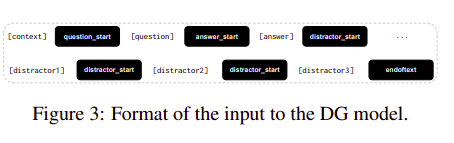

## Data preprocessing

### Downloading data

In [9]:
!wget https://raw.githubusercontent.com/Yifan-Gao/Distractor-Generation-RACE/master/data/data.tar.gz
!tar xvzf data.tar.gz

--2020-12-02 11:13:02--  https://raw.githubusercontent.com/Yifan-Gao/Distractor-Generation-RACE/master/data/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74659681 (71M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  71.20M   198MB/s    in 0.4s    

2020-12-02 11:13:06 (198 MB/s) - ‘data.tar.gz’ saved [74659681/74659681]

distractor/
distractor/race_dev_original.json
distractor/race_test_original.json
distractor/race_test_updated.json
distractor/race_train_updated.json
distractor/race_train_original.json
distractor/race_dev_updated.json


In [ ]:
!wget http://www.cs.cmu.edu/~glai1/data/race/RACE.tar.gz
!tar xvzf RACE.tar.gz


In [8]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [10]:
#!mkdir "processed_data"
!mkdir "/drive/My Drive/Thesis/GPT/processed_data"

mkdir: cannot create directory ‘/drive/My Drive/Thesis/GPT/processed_data’: File exists


In [11]:
import sys
PATH = '/drive/My Drive/Thesis/GPT'
sys.path.append(PATH)

### Converting data

In [34]:
!pip install nlp2
!pip install transformers
!pip install jsonlines

In [35]:
import csv
from statistics import mean
from collections import defaultdict

import nlp2
import jsonlines
from transformers import *
from tqdm.notebook import tqdm


tokenizer = AutoTokenizer.from_pretrained('gpt2')


input_folder = "./distractor"
output_folder = PATH + "/processed_data/"

In [36]:
inputFiles = [f for f in nlp2.get_files_from_dir(input_folder) if 'json' in f]

START_Q = '[questionstart]'
START_A = '[answerstart]'
START_D = '[distractorstart]'
BOS='<|startoftext|>'
EOS ='<|endoftext|>'
UNK ='[unk]'
PAD ='[pad]'

def seq_of_distractors(d):
    return f" {START_D} ".join(d)

In [15]:
for inputFile in tqdm(inputFiles):
    if 'updated' not in inputFile:
        continue

    questions = defaultdict(dict)
    outfile_type = inputFile.split("/")[-1].replace(".json", "")
    print(inputFile, outfile_type)
    with jsonlines.open(inputFile, mode='r') as reader:
        count = 0
        for obj in reader:
            count += 1
            article = " ".join(obj['article']).strip()
            question = " ".join(obj['question']).strip()
            distractor = " ".join(obj['distractor']).strip()
            answer_text = " ".join(obj['answer_text']).strip()
            id = (article + question).replace(" ", '')
            questions[id]['context'] = article
            questions[id]['question'] = question
            questions[id]['answer'] = answer_text
            if 'distractor' in questions[id]:
                questions[id]['distractor'].append(distractor)
            else:
                questions[id]['distractor'] = [distractor]
        print(len(questions), count)

        count_over_512 = 0
        data_simple = []
        data_list = []
        data_list_wo_a = []
        data_sep_list = []
        data_sep_list_wo_a = []
        d_count = []
        for _, item in questions.items():
            c = item['context']
            q = item['question']
            a = item['answer']
            d = item['distractor']
            d_count.append(len(d))
            t_c = tokenizer.tokenize(c)
            #t = tokenizer.tokenize(c + " [SEP] " + q + " [SEP] " + a + " [SEP] "" + " [SEP] ".join(d)")
            t = tokenizer.tokenize(f"{c} {START_Q} {q} {START_A} {a} {START_D} {seq_of_distractors(d)} ")
            if len(t) > 512:
                #t_oth = tokenizer.tokenize(" [SEP] " + q + " [SEP] " + a + " [SEP] " + " [SEP] ".join(d)) # Q+A+D without C
                t_oth = tokenizer.tokenize(f" {START_Q} {q} {START_A} {a} {START_D} {seq_of_distractors(d)} ")
                remain = 512 - len(t_oth)  # how much to delete from context
                t_c = t_c[:remain] # cut the context, not Q/A/D
                if len(t_c + t_oth) > 512: # NB: always false
                    print(len(t))
                    count_over_512 += 1
                    continue
            #t_in = t_c + tokenizer.tokenize(" [SEP] " + q + " [SEP] " + a)
            #t_out = tokenizer.tokenize(" [SEP] ".join(d))
            t_in = t_c + tokenizer.tokenize(f" {START_Q} {q} {START_A} {a}")
            t_out = tokenizer.tokenize(seq_of_distractors(d))

            # updated: prune the distractors which have no semantic relevance with the article or require some world knowledge to generate.
            # cqa: c - context, q - question, a - answer
            # dsep - each distractor is in different sample
            # dall - distractors are joined by [SEP] in one sample
            # _a --- each sample endsup with answer separately
            for oned in d:
                # _cqa_dsep_a
                data_sep_list.append(
                    [tokenizer.convert_tokens_to_string(t_in), tokenizer.convert_tokens_to_string([oned]), a])
                # _cqa_dsep
                data_sep_list_wo_a.append(
                    [tokenizer.convert_tokens_to_string(t_in), tokenizer.convert_tokens_to_string([oned])])
            # _cqad
            data_simple.append([tokenizer.convert_tokens_to_string(t)])
            # _cqa_dall_a ---
            data_list.append([tokenizer.convert_tokens_to_string(t_in), tokenizer.convert_tokens_to_string(t_out), a])
            # _cqa_dall --- 
            data_list_wo_a.append([tokenizer.convert_tokens_to_string(t_in), tokenizer.convert_tokens_to_string(t_out)])

        print(f'Count over 512: {count_over_512}, mean(d_count): {mean(d_count)}')
        
        with open(output_folder + outfile_type + "_simple.csv", 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_simple)

        with open(output_folder + outfile_type + "_cqa_dall_a.csv", 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_list)

        with open(output_folder + outfile_type + "_cqa_dall.csv", 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_list_wo_a)

        with open(output_folder + outfile_type + "_cqa_dsep_a.csv", 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_sep_list)

        with open(output_folder + outfile_type + "_cqa_dsep.csv", 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_sep_list_wo_a)

./distractor/race_dev_updated.json race_dev_updated
5736 12089



KeyError: ignored

In [37]:
output_folder = PATH + "/processed_data/"
output_folder

'/drive/My Drive/Thesis/GPT/processed_data/'

## Joke 

In [38]:
!pip install transformers

In [39]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

In [40]:
model_name = 'gpt2' # gpt2 (small) / gpt2-medium

tokenizer = GPT2Tokenizer.from_pretrained(model_name) 
model = GPT2LMHeadModel.from_pretrained(model_name)

In [41]:
def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

In [42]:
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import os
import json
import csv

class RACEDataset(Dataset):
    def __init__(self, dataset_path):
        super().__init__()
        self.dataset_path = dataset_path
        with open(dataset_path) as f:
            self.samples = f.readlines()
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [44]:
!ls '$output_folder/'

 race_dev_updated_cqa_dall_a.csv    race_test_updated_cqa_dsep.csv
 race_dev_updated_cqa_dall.csv	    race_test_updated_simple.csv
 race_dev_updated_cqa_dsep_a.csv    race_train_updated_cqa_dall_a.csv
 race_dev_updated_cqa_dsep.csv	    race_train_updated_cqa_dall.csv
 race_dev_updated_simple.csv	    race_train_updated_cqa_dsep_a.csv
 race_test_updated_cqa_dall_a.csv   race_train_updated_cqa_dsep.csv
 race_test_updated_cqa_dall.csv     race_train_updated_simple.csv
 race_test_updated_cqa_dsep_a.csv  'Копия race_train_updated_simple.csv'


In [ ]:
import pandas as pd
pd.read_csv(f'{output_folder}/race_train_updated_cqa.csv')

In [45]:
train_dataset = RACEDataset(f'{output_folder}/race_train_updated_cqa_dsep_a.csv')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [46]:
from transformers import AdamW, get_linear_schedule_with_warmup


device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('device', device)

device cuda


In [14]:
# ==== TRAIN ====
from tqdm.notebook import tqdm

BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 3e-5
WARMUP_STEPS = 1000
MAX_SEQ_LEN = 400


model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0
save_steps = 500


global_steps = 0

tmp_jokes_tens = None
models_folder = f"{PATH}/trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in tqdm(range(EPOCHS), desc='TRAIN'):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx,joke in tqdm(enumerate(train_loader), f'epoch {epoch}'):
        global_steps += 1
        #################### "Fit as many joke sequences into MAX_SEQ_LEN sequence as possible" logic start ####
        print(idx, len(joke), joke)
        break
        joke_tens = torch.tensor(tokenizer.encode(joke[0])).unsqueeze(0).to(device)
        
        #Skip sample from dataset if it is longer than MAX_SEQ_LEN
        if joke_tens.size()[1] > MAX_SEQ_LEN:
            continue
        
        #The first joke sequence in the sequence
        if not torch.is_tensor(tmp_jokes_tens):
            tmp_jokes_tens = joke_tens
            continue
        else:
            #The next joke does not fit in so we process the sequence and leave the last joke 
            #as the start for next sequence 
            if tmp_jokes_tens.size()[1] + joke_tens.size()[1] > MAX_SEQ_LEN:
                work_jokes_tens = tmp_jokes_tens
                tmp_jokes_tens = joke_tens
            else:
                #Add the joke to sequence, continue and try to add more
                tmp_jokes_tens = torch.cat([tmp_jokes_tens, joke_tens[:,1:]], dim=1)
                continue
        ################## Sequence ready, process it trough the model ##################
            
        outputs = model(work_jokes_tens, labels=work_jokes_tens)
        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0

        if global_steps % save_steps == 0:
            # Store the model after each epoch to compare the performance of them
            torch.save(model.state_dict(), os.path.join(models_folder, f"{model_name}_race_{epoch}_{global_steps}.pt"))

torch.save(model.state_dict(), os.path.join(models_folder, f"{model_name}_race_{epoch}_{global_steps}.pt"))

EPOCH 0 started==============================


0 4 ['"You may know about "" junk food "" like French fries . But do you know about "" junk sleep "" ? Recently , a British survey found that electronic   products in teenagers bedrooms are affecting their sleep . The survey was done among 1,000 British kids from 12 to 16 . It found that thirty percent of them got just 4 to 7 hours sleep every day . But doctors say they need 8 to 9 hours . Almost a quarter of the kids said they fell asleep more than once a week while watching TV , listening to music or using other electronic products . "" This is very worrying . "" Said Dr Chris Idzikowski , a British expert , "" We call it \' junk sleep \' , It means you do n\'t get enough sleep and the quality of the sleep is bad , too . If you do n\'t get good rest , you do n\'t perform well in school the next day . "" The survey found that 40 percent of the kids felt tired each day , with girls between 13 and 16 feeling the worst . Nearly all the teenagers have a phone , Mp4 or TV IN THEIR BEDROOM 

0 4 ['"Name : Container Gardens by Number Cover price : $ l5.95 Our price : $ 9.49 A book covers 50 easy - to - follow container designs . Each design provides a simple numbered planting plan that shows exactly how to create each display , with an instruction of the finished container and in - depth plant information . The plans are easy to follow and for any type of living space or garden . Name : Off the Beaten Path Cover price : $ 30.00 Our price : $ l9.80 The best - selling Reader \'s Digest travel book has 40 % new content including over 200 new places of interest , over 200 new full - color photographs , and all - new , up - to - date maps . It introduces over l , 000 of the United States \' most beautiful must - see sights . Name : l80l Home Treatment Cover price : $ 40.00 Our price : $ 29.96 Plenty of health problems can be solved at home . Each and every treatment will be tested by a doctor to make sure it is safe and sound . Lots of conditions are covered , from headaches , s

0 4 ['"Police Officer Tidwell left the station after 8 a.m. on Sunday . He was looking forward to his day of rest . By habit he took a short cut down the path behind prefix = st1 /Digby Hall Road . Suddenly he saw a man climbing down a drain - pipe from an open bedroom window of number 29 . Quietly Tidwell walked into the garden . The man had just reached the ground when he felt his arm grasped . "" It seems an unlikely adventure . Would you mind explaining ? "" said the officer . The man was frightened , saying , "" I know what \'s on your mind , officer , but it is a mistake . ""   "" It \'s part of my job to take an interest in unusual events . I think you \'ve just left this house in a manner other than the customary one . "" Tidwell took out his notebook and a pen . "" Name , address and your job and then , please , tell me your story . ""   "" Charlie Crane , Lorry Driver , from Nottingham , 51 Brecon Street . My story ... "" "" Yes , What were you doing , Mr. Crane ? ""   "" Wel

In [24]:
from tqdm.notebook import tqdm

MODEL_EPOCH = 4

models_folder = f"{PATH}/trained_models"
model_path = os.path.join(models_folder, f"{model_name}_race_{epoch}_{global_steps}.pt")
model.load_state_dict(torch.load(model_path))

jokes_output_file_path = f'generated_{MODEL_EPOCH}.jokes'

model.eval()
if os.path.exists(jokes_output_file_path):
    os.remove(jokes_output_file_path)
    
joke_num = 0
with torch.no_grad():
   
    for joke_idx in tqdm(range(1000), desc='generate'):
    
        joke_finished = False

        cur_ids = torch.tensor(tokenizer.encode("JOKE:")).unsqueeze(0).to(device)

        for i in range(100):
            outputs = model(cur_ids, labels=cur_ids)
            loss, logits = outputs[:2]
            softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
            if i < 3:
                n = 20
            else:
                n = 3
            next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
            cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

            if next_token_id in tokenizer.encode(ENDOFTEXT):
                joke_finished = True
                break

        
        if joke_finished:
            
            joke_num = joke_num + 1
            
            output_list = list(cur_ids.squeeze().to('cpu').numpy())
            output_text = tokenizer.decode(output_list)

            with open(jokes_output_file_path, 'a') as f:
                f.write(f"{output_text} \n\n")

## Fine-tune

Source: https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=vCPohrZ-CTWu

In [47]:
!pip install transformers

In [48]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
!nvidia-smi

Wed Dec  2 14:49:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
train_df = pd.read_csv(f"{PATH}/processed_data/race_train_updated_cqa_dsep.csv", header=None)
train_df.head()

,0,1
0,Last week I talked with some of my students ab...,it 's right for graduates to ask for others to...
1,Last week I talked with some of my students ab...,Young Graduates ' Opinion About Cosmetic Surgery
2,"YUZHOU , HENAN -An accident in a central China...",Death Toll Rises in an Accident in China
3,"YUZHOU , HENAN -An accident in a central China...",An Accident in Central China
4,"YUZHOU , HENAN -An accident in a central China...",Coal Mine Accidents in China


In [57]:
sample = 1
print(train_df[0].iloc[sample])
print(train_df[1].iloc[sample])

Last week I talked with some of my students about what they wanted to do after they graduated , and what kind of job prospects   they thought they had . Given that I teach students who are training to be doctors , I was surprised do find that most thought that they would not be able to get the jobs they wanted without " outside help " . " What kind of help is that ? " I asked , expecting them to tell me that they would need a    or family friend to help them out . " Surgery , " one replied . I was pretty alarmed by that response . It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job . One girl told me that she was considering surgery to increase her height . " They break your legs , put in special extending screws , and slowly expand the gap between the two ends of the bone as it re - grows , you can get at least 5 cm taller ! " At that point , I was shocked . I am short , I ca n't deny that , but I do

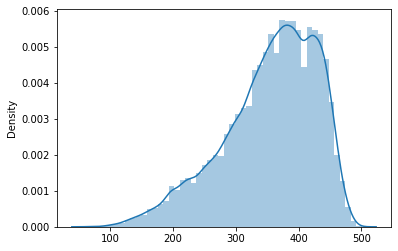

In [58]:
texts = train_df[0].copy()

doc_lengths = []

for text in texts:
    # get rough token count distribution
    tokens = nltk.word_tokenize(text)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [59]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [60]:
np.average(doc_lengths)

354.4817981160817

In [61]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token=BOS, 
                                          eos_token=EOS, 
                                          unk_token=UNK,
                                          pad_token=PAD) #gpt2-medium???

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [62]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))
#print("The unknown token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.unk_token_id), tokenizer.unk_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token [pad] has the id 50258


In [112]:
from tqdm.notebook import tqdm

"""class GPT2Dataset(Dataset):
    def __init__(self, txt_file, tokenizer, gpt2_type="gpt2", max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        with open(txt_file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            for row in tqdm(reader, 'reading'):
                assert len(row) == 2
                
                encodings_dict = tokenizer(BOS + txt + EOS, 
                                            truncation=True, 
                                            max_length=max_length, 
                                            padding="max_length")

                self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
                self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] """


class GPT2Dataset(Dataset):
    def __init__(self, txt_file, tokenizer, gpt2_type="gpt2", max_length=768):
        self.tokenizer = tokenizer
        self.inputs = []
        self.outputs = []

        df = pd.read_csv(txt_file, header=None)
        print(df.head())

        for i, row in tqdm(df.iterrows(), 'reading'):
            assert len(row) == 2
            
            encodings_in = tokenizer(BOS + row[0] + EOS, 
                                        truncation=True, 
                                        max_length=max_length, 
                                        padding="max_length")
            encodings_out = tokenizer(BOS + row[1] + EOS, 
                                        truncation=True, 
                                        max_length=max_length, 
                                        padding="max_length")

            self.inputs.append(torch.tensor([encodings_in['input_ids'],
                                            encodings_in['attention_mask']]))
            self.outputs.append(torch.tensor([encodings_out['input_ids'],
                                             encodings_out['attention_mask']]))
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx][0], self.inputs[idx][1], self.outputs[idx][0],  self.outputs[idx][1]

In [113]:
train_dataset = GPT2Dataset(f"{PATH}/processed_data/race_train_updated_cqa_dsep.csv", 
                      tokenizer, 
                      max_length=768)

val_dataset = GPT2Dataset(f"{PATH}/processed_data/race_dev_updated_cqa_dsep.csv", 
                      tokenizer, 
                      max_length=768)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

                                                   0                                                  1
0  Last week I talked with some of my students ab...  it 's right for graduates to ask for others to...
1  Last week I talked with some of my students ab...   Young Graduates ' Opinion About Cosmetic Surgery
2  YUZHOU , HENAN -An accident in a central China...           Death Toll Rises in an Accident in China
3  YUZHOU , HENAN -An accident in a central China...                       An Accident in Central China
4  YUZHOU , HENAN -An accident in a central China...                       Coal Mine Accidents in China



                                                   0                                                  1
0  Looking good , feeling good Born to a model mo...                           wore the latest fashions
1  Looking good , feeling good Born to a model mo...                was fond of hand - painted clothing
2  Looking good , feeling good Born to a model mo...            Creating basic designs in high school .
3  Looking good , feeling good Born to a model mo...      Wearing high - quality clothes all the time .
4  I 'm sure many of you have seen Star Wars , Ju...  Cloning itself gives parents great power over ...



96,501 training samples
12,089 validation samples


In [114]:
batch_size = 2

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [115]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [116]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 500

In [117]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [119]:
sample = next(iter(validation_dataloader))
v_input_ids = sample[0].to(device)
v_masks = sample[1].to(device)
v_labels = sample[2].to(device) 

tensor([[50257, 15784,   922,  ..., 50258, 50258, 50258],
        [50257, 15784,   922,  ..., 50258, 50258, 50258]], device='cuda:0')

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

tensor([[50257,    86,   382,  ..., 50258, 50258, 50258],
        [50257,  9776, 16245,  ..., 50258, 50258, 50258]], device='cuda:0')


In [120]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [126]:


pad_token_id, bos_token_id

(50258, 50257)

In [131]:
from tqdm.notebook import tqdm

total_t0 = time.time()
training_stats = []
global_step = 0
models_folder = f"{PATH}/trained_models"

model = model.to(device)
pad_token_id = tokenizer(PAD)['input_ids'][0]
bos_token_id = tokenizer(BOS)['input_ids'][0]


for epoch_i in tqdm(range(0, epochs)):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # inputids: PQA 
    # labels:   -100, -100, -100, D (maybe special token/separator between -100 and D)


    for step, batch in tqdm(enumerate(train_dataloader), f'Epoch {epoch_i}'):
        global_step += 1

        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device) 
        b_labels_masks = batch[3].to(device)
        

        model.zero_grad()        
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            
            model.eval()
            sample = next(iter(validation_dataloader))
            v_input_ids = sample[0].to(device)
            v_masks = sample[1].to(device)
            v_labels = sample[2].to(device) 
            v_labels_masks = sample[3].to(device)  

            sample_outputs = model.generate( # TODO generate??
                                    input_ids=v_input_ids,
                                    attention_masks=v_masks,
                                    pad_token_id=pad_token_id,
                                    bos_token_id=bos_token_id,
                                    do_sample=True,   
                                    top_k=50, 
                                    #max_length = 20,
                                    max_length=len(input_ids),
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

            torch.save(model.state_dict(), os.path.join(models_folder, f"{model_name}_race_{epoch}_{global_step}.pt"))
            

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(model.state_dict(), os.path.join(models_folder, f"{model_name}_race_{epoch}_final.pt"))



======== Epoch 1 / 5 ========
Training...


  Batch   500  of  48,251. Loss: 0.07467883825302124.   Elapsed: 0:01:29.




NameError: ignored

##

## Tfkit

In [2]:
!pip install tfkit


     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 317kB 15.1MB/s 
     |████████████████████████████████| 1.1MB 12.2MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 3.0MB 66.4MB/s 
     |████████████████████████████████| 1.1MB 67.6MB/s 
     |████████████████████████████████| 890kB 64.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=38d48d1d5d924cdd01a35406519563ff09e5000a1b9165fc2d798ed1a6699a87
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [5]:
%%writefile /usr/local/lib/python3.6/dist-packages/tfkit/utility/logger.py
import csv
import os
from torch.utils import tensorboard as board


class Logger:

    def __init__(self, savedir, logfilename="message.log", metricfilename="metric.log", tensorboard=False):
        self.savedir = savedir
        self.logfilepath = os.path.join(savedir, logfilename)
        self.metricfilepath = os.path.join(savedir, metricfilename)
        self.tensorboard_writer = board.SummaryWriter() if tensorboard else None

    def write_log(self, *args):
        line = ' '.join([str(a) for a in args])
        with open(self.logfilepath, "a", encoding='utf8') as log_file:
            log_file.write(line + '\n')
        print(line)

    def write_metric(self, *args):
        if self.tensorboard_writer:
            self.tensorboard_writer.add_scalar(*args)
        else:
            with open(self.metricfilepath, "a", encoding='utf8') as log_file:
                writer = csv.writer(log_file)
                writer.writerow(args)

Overwriting /usr/local/lib/python3.6/dist-packages/tfkit/utility/logger.py


In [64]:
#/usr/local/lib/python3.6/dist-packages/tfkit/utility/logger.py
"""import csv
import os
from torch.utils import tensorboard as board


class Logger:

    def __init__(self, savedir, logfilename="message.log", metricfilename="metric.log", tensorboard=False):
        self.savedir = savedir
        self.logfilepath = os.path.join(savedir, logfilename)
        self.metricfilepath = os.path.join(savedir, metricfilename)
        self.tensorboard_writer = board.SummaryWriter() if tensorboard else None

    def write_log(self, *args):
        line = ' '.join([str(a) for a in args])
        with open(self.logfilepath, "a", encoding='utf8') as log_file:
            log_file.write(line + '\n')
        print(line)

    def write_metric(self, *args):
        if self.tensorboard_writer:
            self.tensorboard_writer.add_scalar(*args)
        else:
            with open(self.metricfilepath, "a", encoding='utf8') as log_file:
                writer = csv.writer(log_file)
                writer.writerow(args)
"""

'/drive/My Drive/Thesis/GPT'

In [17]:
!tfkit-train --maxlen 512 --savedir ./race_cqa_gen_d/ --train '$PATH/processed_data/race_train_updated_cqa_dsep_a.csv' --test '$PATH/data_preprocessing/processed_data/race_test_updated_cqa_dsep_a.csv' --model onebyone --tensorboard --config bert-base-cased --batch 30 --epoch 1;


Выходные данные были обрезаны до нескольких последних строк (5000).
65437it [40:46, 25.34it/s]
65441it [40:46, 25.63it/s]
65444it [40:46, 26.45it/s]
65448it [40:47, 27.08it/s]
65451it [40:47, 27.11it/s]
65454it [40:47, 26.43it/s]
65457it [40:47, 26.04it/s]
65461it [40:47, 28.16it/s]
65464it [40:47, 26.19it/s]
65467it [40:47, 24.01it/s]
65470it [40:48, 20.30it/s]
65473it [40:48, 20.21it/s]
65476it [40:48, 22.25it/s]
65479it [40:48, 21.93it/s]
65482it [40:48, 20.00it/s]
65485it [40:48, 18.45it/s]
65487it [40:48, 18.75it/s]
65491it [40:48, 22.17it/s]
65495it [40:49, 25.12it/s]
65499it [40:49, 26.93it/s]
65503it [40:49, 29.57it/s]
65507it [40:49, 31.22it/s]
65511it [40:49, 32.19it/s]
65515it [40:49, 31.78it/s]
65519it [40:49, 31.39it/s]
65523it [40:49, 32.37it/s]
65528it [40:50, 34.27it/s]
65532it [40:50, 32.63it/s]
65536it [40:50, 28.03it/s]
65540it [40:50, 28.68it/s]
65544it [40:50, 29.74it/s]
65548it [40:50, 28.86it/s]
65551it [40:50, 26.82it/s]
65554it [40:51, 26.99it/s]
65557it [40:51

In [19]:
!ls runs
!ls race_cqa_gen_d

Dec02_11-09-25_5c5ba0f9bb9f  Dec02_12-15-48_5c5ba0f9bb9f
Dec02_11-13-38_5c5ba0f9bb9f
message.log


In [77]:
!ls

data.tar.gz  distractor  race_cqa_gen_d  runs  sample_data


In [78]:
!ls race_cqa_gen_d

message.log


In [79]:
%cat race_cqa_gen_d/message.log

TRAIN PARAMETER
batch : 30
lr : [5e-05]
epoch : 3
maxlen : 512
savedir : ./race_cqa_gen_d/
add_tokens : 0
train : ['/drive/My', 'Drive/Thesis/GPT/processed_data/race_train_updated_cqa_dsep_a.csv']
test : ['/drive/My', 'Drive/Thesis/GPT/data_preprocessing/processed_data/race_test_updated_cqa_dsep_a.csv']
model : ['onebyone']
config : bert-base-cased
seed : 609
worker : 8
grad_accum : 1
tensorboard : True
cache : False
panel : False
TRAIN PARAMETER
batch : 30
lr : [5e-05]
epoch : 3
maxlen : 512
savedir : ./race_cqa_gen_d/
add_tokens : 0
train : ['/drive/My Drive/Thesis/GPT/processed_data/race_train_updated_cqa_dsep_a.csv']
test : ['/drive/My', 'Drive/Thesis/GPT/data_preprocessing/processed_data/race_test_updated_cqa_dsep_a.csv']
model : ['onebyone']
config : bert-base-cased
seed : 609
worker : 8
grad_accum : 1
tensorboard : True
cache : False
panel : False
TRAIN PARAMETER
batch : 30
lr : [5e-05]
epoch : 3
maxlen : 512
savedir : ./race_cqa_gen_d/
add_tokens : 0
train : ['/drive/My Drive/T